<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/6_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks

This is merely a copy of the tutorial on "Gradient descent on a Softmax cross-entropy cost function" found [here](https://madalinabuzau.github.io/2016/11/29/gradient-descent-on-a-softmax-cross-entropy-cost-function.html).

I adapted it to our running example of Iris classification and added history plots and some documentation.

Import useful libraries.

In [ ]:
from sklearn.datasets import make_classification 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split


Import Iris data.

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Create a class for a Softmax linear classifier. Methods:
* $\verb|get_loss_grads|$ returns the gradients of the loss wrt. the weights and biases. It is used internally in the gradient descent methods.
* $\verb|train|$ optimizes the loss using gradient descent for a fixed number of iterations, i.e., it trains the model by iteratively adjusting the initial weights and biases in the direction of the negative gradient vector with smaller and smaller steps as the gradient vector approaches zero.  
* $\verb|train_early_stopping|$ same as $\verb|train|$, but it only stops if the accuracy on the validation set doesn't improve for a number of iterations.
* $\verb|predict|$ uses the model, i.e., the current weights and biases, for predicting classes.
* $\verb|eval|$ uses the model, i.e., the current weights and biases, for evaluating the accuraxy of the prdiction.

In [ ]:
class Softmax(object):    

  def __init__(self):
    self.W = None
    self.b = None
    self.history = []
    
  def get_loss_grads(self, X, y, reg, n_samples):  
    # Linear mapping scores
    scores = np.dot(X, self.W)+self.b

    # Normalize the scores beforehand with max as zero to avoid 
    # computational problems with the exponential
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))

    # Softmax activation
    probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)

    # Logloss of the correct class for each of our samples
    correct_logprobs = -np.log(probs[np.arange(n_samples), y])

    # Compute the average loss
    loss = np.sum(correct_logprobs)/n_samples

    # Add regularization using the L2 norm
    reg_loss = 0.5*reg*np.sum(self.W*self.W)
    loss += reg_loss
    
    # Gradient of the loss with respect to scores
    dscores = probs.copy()

    # Substract 1 from the scores of the correct class
    dscores[np.arange(n_samples),y] -= 1
    dscores /= n_samples

    # Gradient of the loss with respect to weights
    dW = X.T.dot(dscores) 

    # Add gradient regularization 
    dW += reg*self.W

    # Gradient of the loss with respect to biases
    db = np.sum(dscores, axis=0, keepdims=True)

    return loss, dW, db


  def train(self, X, y, learning_rate=1e-4, reg=0.5, num_iters=500):
    # Get useful parameters
    n_features, n_samples = X.shape[1], X.shape[0]   
    n_samples = X.shape[0] 
    n_classes = len(np.unique(y))
    
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))
        
    for iter in range(num_iters):
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X, y, reg, n_samples)
      
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db

      # Compute validation accuracy
      accuracy = self.eval(X,y)
      self.history.append(accuracy)
        
        
  def train_early_stopping(self, X_train, y_train, X_val, y_val, learning_rate=1e-4, reg=0.5, early_stopping_rounds=200):
    # Get useful parameters_train
    n_features, n_samples = X_train.shape[1], X_train.shape[0]   
    n_samples = X_train.shape[0] 
    n_classes = len(np.unique(y))
    
    # Initialize weights from a normal distribution and the biases with zeros
    if (self.W is None) & (self.b is None):
      np.random.seed(2016) # for reproducible results
      self.W = np.random.normal(loc=0.0, scale=1e-4, size=(n_features, n_classes))
      self.b = np.zeros((1, n_classes))

    # Stores best accuracy found 
    best_val_accuracy = -1
    
    # Stores the weights and biases of the best iteration
    best_weights, best_bias = None, None
    
    # Counts the number of no improvements in the accuracy
    no_improvement = 0
    
    # Boolean variable which helps us get out of the while loop
    keep_training = True
        
    while keep_training:
        
      # Get loss and gradients
      loss, dW, db = self.get_loss_grads(X_train, y_train, reg, n_samples)
    
      # update weights and biases
      self.W -= learning_rate*dW
      self.b -= learning_rate*db
              
      # Compute validation accuracy
      val_accuracy = self.eval(X_val,y_val)
      train_accuracy = self.eval(X_train,y_train)

      self.history.append([val_accuracy,train_accuracy])

      if val_accuracy>best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights, best_bias = self.W, self.b
        # reset count
        no_improvement = 0
      else:
        no_improvement += 1
        
      if no_improvement == early_stopping_rounds:
        self.W, self.b = best_weights, best_bias
        keep_training = False
      
      
  def predict(self, X):
    y_pred = np.dot(X, self.W)+self.b
    y_pred=np.argmax(y_pred, axis=1)

    return y_pred

  def eval(self, X, y):
    return np.mean(self.predict(X)==y)

Function for plotting the training history.

In [ ]:
def plot_history(history, labels):
  x = range(len(history))
  hist_arr = np.asarray(softmax.history)
  if hist_arr.ndim==1:
    plt.plot(x, hist_arr, label=labels );
  else:
    i = 0
    for hist_row in hist_arr.transpose():
      plt.plot(x, hist_row, label = labels[i]);
      i += 1 
    
  plt.title("Improvement of accuracy over epochs")
  plt.xlabel("epochs")
  plt.ylabel("accuracy");
  plt.legend();

Train and assess the model on the whole dataset using a fixed number of training iterations.

Accuracy 0.8866666666666667


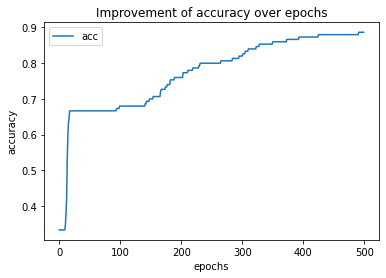

In [ ]:
softmax = Softmax()
softmax.train( X, y, learning_rate=1e-2, reg=0.1, num_iters=500)
print('Accuracy', softmax.eval(X, y))
plot_history(softmax.history, 'acc')

Train and assess the model on the dataset split into training and validation subsets using early stopping.

Training accuracy 0.95
Validation accuracy 1.0


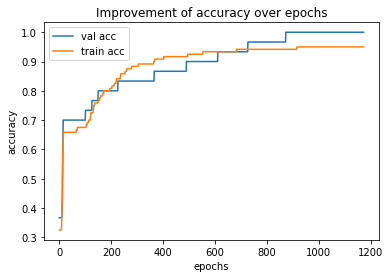

In [ ]:
# Split dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #random_state=2

# Train with early stopping
softmax = Softmax()
softmax.train_early_stopping( X_train, y_train, X_val, y_val, learning_rate=1e-2, reg=0.1, early_stopping_rounds=300)
print('Training accuracy', softmax.eval(X_train, y_train))
print('Validation accuracy', softmax.eval(X_val, y_val))
plot_history(softmax.history, ['val acc', 'train acc'])